## 导入依赖包

In [1]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import tensorflow as tf
import deepctr.models
from deepctr.models import DeepFM,DeepFEFM,WDL,xDeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

In [2]:
%config InlineBackend.figure_format='svg'#矢量图设置

In [3]:
# help(deepctr.models.DeepFEFM)       
help(deepctr.models.xDeepFM)


Help on function xDeepFM in module deepctr.models.xdeepfm:

xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 128, 64), cin_layer_size=(128, 128), cin_split_half=True, cin_activation='relu', l2_reg_linear=1e-05, l2_reg_embedding=1e-05, l2_reg_dnn=0, l2_reg_cin=0, seed=1024, dnn_dropout=0, dnn_activation='relu', dnn_use_bn=False, task='binary')
    Instantiates the xDeepFM architecture.
    
    :param linear_feature_columns: An iterable containing all the features used by linear part of the model.
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of deep net
    :param cin_layer_size: list,list of positive integer or empty list, the feature maps  in each hidden layer of Compressed Interaction Network
    :param cin_split_half: bool.if set to True, half of the feature maps in each hidden will co

In [4]:
data = pd.read_csv("./output/clean_end_nature_data0317.csv",index_col=0)

print(data.isnull().sum().sum())

dense_features_origin = data.select_dtypes(exclude=["category", "object"]).columns.tolist()
dense_features_origin.remove("贷款现状")  

sparse_features_origin = data.select_dtypes(include=["category", "object"]).columns.tolist()


C:\Users\luyao\.conda\envs\pt2\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


0


In [5]:
data

,申请的贷款金额,贷款周期,贷款利率,分期金额,职位,就业年限,房产权,年收入,收入来源是否已核实,贷款现状,...,不包括抵押贷款的总信贷余额,银行卡总信用额度/信用额度,总分期高信用/信用额度,次申请人的FICO所给评级范围（高）,次申请人的FICO所给评级范围（低）,由于困难计划，借款人预计支付少于合同每月付款金额的月份数,是否有共同借款人,子评级(连续),借款人最早信用报告开立的年份,贷款融资的年份
0,5000.0,36,10.65,162.87,lose_info,10.0,RENT,24000.0,Verified,1,...,37615.0,15800.0,32399.0,0.0,0.0,0.0,0,7,1985,2011
1,2500.0,60,15.27,59.83,other,0.5,RENT,30000.0,Source Verified,0,...,37615.0,15800.0,32399.0,0.0,0.0,0.0,0,14,1999,2011
2,2400.0,36,15.96,84.33,lose_info,10.0,RENT,12252.0,Not Verified,1,...,37615.0,15800.0,32399.0,0.0,0.0,0.0,0,15,2001,2011
3,10000.0,36,13.49,339.31,other,10.0,RENT,49200.0,Source Verified,1,...,37615.0,15800.0,32399.0,0.0,0.0,0.0,0,11,1996,2011
4,3000.0,60,12.69,67.79,other,0.0,RENT,80000.0,Source Verified,1,...,37615.0,15800.0,32399.0,0.0,0.0,0.0,0,10,1996,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105446,24000.0,60,23.99,690.30,other,0.5,RENT,107000.0,Source Verified,0,...,60812.0,28200.0,64422.0,0.0,0.0,0.0,0,22,1995,2017
105447,10000.0,36,7.99,313.32,rn,10.0,MORTGAGE,65000.0,Source Verified,1,...,55863.0,34800.0,70203.0,0.0,0.0,0.0,0,5,1993,2017
105448,10050.0,36,16.99,358.26,other,8.0,RENT,37000.0,Not Verified,0,...,14300.0,9000.0,0.0,0.0,0.0,0.0,0,16,1993,2017
105449,6000.0,36,11.44,197.69,other,5.0,RENT,41000.0,Source Verified,1,...,26201.0,8100.0,34076.0,0.0,0.0,0.0,0,9,1990,2017


In [6]:
def colunms_names_into_english(dense_features_origin,sparse_features_origin,colunms_names):
  dense_features_dict = {}
  sparse_features_dict = {}
  
  
  for index,val in enumerate(dense_features_origin): 
    dense_features_dict[val] = "dense" + str(index+1)
  dense_features = list(dense_features_dict.values())
  
  
  for index,val in enumerate(sparse_features_origin): 
    sparse_features_dict[val] = "sparse" + str(index+1)
  sparse_features = list(sparse_features_dict.values())
  
  dense_features_dict.update(sparse_features_dict) 
  
  columns_english_name = []
  
  for i in colunms_names:
    for key,val in dense_features_dict.items():
      if i=="贷款现状":
        columns_english_name.append("label")
        break
      elif i == key:
        columns_english_name.append(val)
        break
  
  return dense_features,sparse_features,columns_english_name

In [7]:
dense_features,sparse_features,columns_english_name = colunms_names_into_english(
  dense_features_origin,sparse_features_origin,data.columns.tolist())

In [8]:
data.columns = columns_english_name
target = ['label']

In [9]:
# 1.Label Encoding for sparse features,and do simple Transformation for dense features
# 1.对稀疏特征进行标签编码，对密集特征进行简单变换

for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [10]:
# 2.count #unique features for each sparse field,and record dense feature field name
# &统计每个稀疏字段的#唯一特征，并记录密集特征字段名称

## ^将sparse_features 稀疏特征的每一个列变成SparseFeat类   
## ^将dense_features 稠密特征的每一个列变成DenseFeat类 
## ^即将特征变成了embedding  

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].nunique(),embedding_dim=4 )
                        for i,feat in enumerate(sparse_features)] + [DenseFeat(feat, 1,)
                      for feat in dense_features]

In [11]:
fixlen_feature_columns[0]

SparseFeat(name='sparse1', vocabulary_size=21, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001998588D208>, embedding_name='sparse1', group_name='default_group', trainable=True)

In [12]:
len(data[sparse_features[0]].unique())

21

In [13]:
## ^将经变成embedding的特征分别传给  dnn与线性部分

In [14]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [15]:
len(linear_feature_columns)

75

In [16]:
linear_feature_columns

[SparseFeat(name='sparse1', vocabulary_size=21, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001998588D208>, embedding_name='sparse1', group_name='default_group', trainable=True),
 SparseFeat(name='sparse2', vocabulary_size=4, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001998588D048>, embedding_name='sparse2', group_name='default_group', trainable=True),
 SparseFeat(name='sparse3', vocabulary_size=3, embedding_dim=4, use_hash=False, vocabulary_path=None, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x000001998588D240>, embedding_name='sparse3', group_name='default_group', trainable=True),
 SparseFeat(name='sparse4', vocabulary_size=14, embedding_dim=4, use_has

In [17]:
len(dnn_feature_columns)

75

In [18]:
data

,dense1,dense2,dense3,dense4,sparse1,dense5,sparse2,dense6,sparse3,label,...,dense59,dense60,dense61,dense62,dense63,dense64,dense65,dense66,dense67,dense68
0,0.113924,0.0,0.207944,0.092099,4,1.00,3,0.000218,2,1,...,0.011037,0.010070,0.015414,0.0,0.0,0.0,0.0,0.176471,0.619048,0.307692
1,0.050633,1.0,0.387850,0.032014,8,0.05,3,0.000273,1,0,...,0.011037,0.010070,0.015414,0.0,0.0,0.0,0.0,0.382353,0.785714,0.307692
2,0.048101,0.0,0.414720,0.046300,4,1.00,3,0.000111,0,1,...,0.011037,0.010070,0.015414,0.0,0.0,0.0,0.0,0.411765,0.809524,0.307692
3,0.240506,0.0,0.318536,0.194985,8,1.00,3,0.000447,1,1,...,0.011037,0.010070,0.015414,0.0,0.0,0.0,0.0,0.294118,0.750000,0.307692
4,0.063291,1.0,0.287383,0.036655,8,0.00,3,0.000727,1,1,...,0.011037,0.010070,0.015414,0.0,0.0,0.0,0.0,0.264706,0.750000,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105446,0.594937,1.0,0.727414,0.399656,8,0.05,3,0.000973,1,0,...,0.017843,0.017973,0.030649,0.0,0.0,0.0,0.0,0.617647,0.738095,0.769231
105447,0.240506,0.0,0.104361,0.179830,14,1.00,0,0.000591,1,1,...,0.016391,0.022180,0.033400,0.0,0.0,0.0,0.0,0.117647,0.714286,0.769231
105448,0.241772,0.0,0.454829,0.206035,8,0.80,3,0.000336,0,0,...,0.004196,0.005736,0.000000,0.0,0.0,0.0,0.0,0.441176,0.714286,0.769231
105449,0.139241,0.0,0.238707,0.112403,8,0.50,3,0.000373,1,1,...,0.007688,0.005163,0.016212,0.0,0.0,0.0,0.0,0.235294,0.678571,0.769231


In [19]:
# 3.generate input data for model
## &train 与 test 都来自于data  train_model_input,test_model_input 也来自于data
train, test = train_test_split(data, test_size=0.2, random_state=2022)
## ^对每一个维度都做一个输入  最后是一个字典 '列名'：[列值]
train_model_input = {name:train[name] for name in feature_names}
test_model_input = {name:test[name] for name in feature_names}

In [20]:
train_model_input

{'sparse1': 63232      8
 146560     8
 60085     12
 69809      8
 48436      8
           ..
 32264      8
 63238      8
 107843     8
 142456     8
 78175      4
 Name: sparse1, Length: 1488264, dtype: int32,
 'sparse2': 63232     0
 146560    3
 60085     0
 69809     3
 48436     3
          ..
 32264     3
 63238     0
 107843    3
 142456    3
 78175     0
 Name: sparse2, Length: 1488264, dtype: int32,
 'sparse3': 63232     1
 146560    0
 60085     1
 69809     1
 48436     1
          ..
 32264     0
 63238     1
 107843    2
 142456    2
 78175     2
 Name: sparse3, Length: 1488264, dtype: int32,
 'sparse4': 63232     9
 146560    2
 60085     1
 69809     2
 48436     9
          ..
 32264     4
 63238     2
 107843    2
 142456    2
 78175     2
 Name: sparse4, Length: 1488264, dtype: int32,
 'sparse5': 63232      3
 146560    37
 60085     23
 69809     31
 48436     26
           ..
 32264      3
 63238     25
 107843    30
 142456     9
 78175     37
 Name: sparse5, Leng

## 模型训练

### 1 deepfm

In [22]:
1+1=2

2

In [23]:
epochs = 50

In [24]:
# 4.Define Model,train,predict and evaluate
##  model来自于   tf.keras.models.Model  

deepfm = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
deepfm.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )


## &train 与 test 都来自于data  train_model_input,test_model_input 也来自于data
history = deepfm.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=epochs, verbose=2, validation_split=0.2, )

Epoch 1/50
4651/4651 - 24s - loss: 0.4358 - binary_crossentropy: 0.4358 - val_loss: 0.4287 - val_binary_crossentropy: 0.4287
Epoch 2/50
4651/4651 - 23s - loss: 0.4267 - binary_crossentropy: 0.4266 - val_loss: 0.4231 - val_binary_crossentropy: 0.4230
Epoch 3/50
4651/4651 - 36s - loss: 0.4248 - binary_crossentropy: 0.4247 - val_loss: 0.4231 - val_binary_crossentropy: 0.4231
Epoch 4/50
4651/4651 - 35s - loss: 0.4237 - binary_crossentropy: 0.4237 - val_loss: 0.4244 - val_binary_crossentropy: 0.4243
Epoch 5/50
4651/4651 - 19s - loss: 0.4229 - binary_crossentropy: 0.4228 - val_loss: 0.4212 - val_binary_crossentropy: 0.4211
Epoch 6/50
4651/4651 - 19s - loss: 0.4222 - binary_crossentropy: 0.4222 - val_loss: 0.4223 - val_binary_crossentropy: 0.4222
Epoch 7/50
4651/4651 - 20s - loss: 0.4217 - binary_crossentropy: 0.4216 - val_loss: 0.4220 - val_binary_crossentropy: 0.4219
Epoch 8/50
4651/4651 - 22s - loss: 0.4212 - binary_crossentropy: 0.4212 - val_loss: 0.4208 - val_binary_crossentropy: 0.4207


In [25]:
y_proba = deepfm.predict(test_model_input, batch_size=256)

print("test LogLoss", round(log_loss(test[target].values, y_proba), 4))
print("test AUC", round(roc_auc_score(test[target].values, y_proba), 4))

test LogLoss nan
test AUC 0.7491


C:\Users\luyao\.conda\envs\pt2\lib\site-packages\sklearn\metrics\_classification.py:2283: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
C:\Users\luyao\.conda\envs\pt2\lib\site-packages\sklearn\metrics\_classification.py:2283: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [26]:
deepfm.save_weights("./output/deepfm_weight.h5")

#### 载入训练好的模型

In [21]:
deepfm = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
deepfm.load_weights("./output/deepfm_weight.h5")

In [22]:
from sklearn.metrics import classification_report,confusion_matrix,plot_roc_curve,roc_auc_score,f1_score
def func_out_y_pred(y_proba):
  alist = []
  for i in y_proba:
    if i >= 0.5:
      alist.append(1)
    else:
      alist.append(0)
  return alist

In [23]:
from sklearn.metrics import roc_curve,roc_auc_score,auc 
import numpy as np
import matplotlib.pyplot as plt

def print_ks_auc_score(y_test,y_proba,model_name):
  fpr_keras,tpr_keras,thresholds= roc_curve(np.array(y_test),y_proba)
  print ('KS:',max(tpr_keras-fpr_keras))
  print("roc_auc_sroce: ",roc_auc_score(test[target], y_proba))
  
  auc_keras = auc(fpr_keras, tpr_keras)
  print("auc: ",auc_keras)
  
  y_pred = func_out_y_pred(y_proba)
  print("f1 score:",f1_score(y_test,y_pred,average="binary"))
  pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).style.format({"0":"{:.2%}","1":"{:.2%}"})
  
  plt.figure(figsize=(10,6))
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label=model_name +'  (auc = {:.3f})'.format(auc_keras))
  # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()
  
  # plt.figure(2)
  # plt.xlim(0, 0.2)
  # plt.ylim(0.8, 1)
  # plt.plot([0, 1], [0, 1], 'k--')
  # plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  # # plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
  # plt.xlabel('False positive rate')
  # plt.ylabel('True positive rate')
  # plt.title('ROC curve (zoomed in at top left)')
  # plt.legend(loc='best')
  # plt.show()

KS: 0.36449839343285056
roc_auc_sroce:  0.7491344148112699
auc:  0.7491344148112699
f1 score: 0.8948900043951976


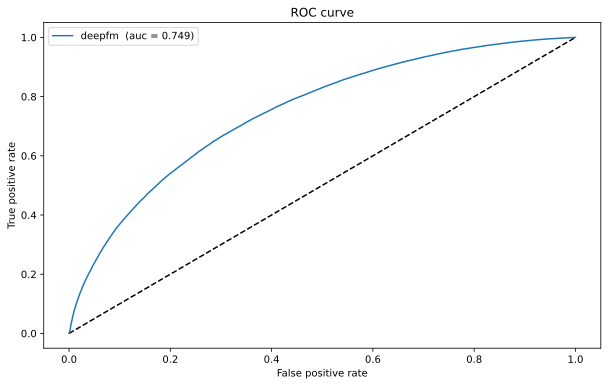

f1 score: 0.8948900043951976


,precision,recall,f1-score,support
0,59.45%,18.99%,0.2878,72536.000000
1,83.16%,96.86%,0.8949,299531.000000


In [24]:
y_test = test[target]
y_proba = deepfm.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,"deepfm")

y_pred = func_out_y_pred(y_proba)
print("f1 score:",f1_score(y_test,y_pred,average="binary"))
pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).iloc[:,:2].T.style.format(
  {"precision":"{:.2%}","recall":"{:.2%}","f1-score":"{:.4f}"})

### 2 xdeepfm

In [31]:
# 4.Define Model,train,predict and evaluate
##  model来自于   tf.keras.models.Model  

xdeepfm = xDeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
xdeepfm.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

## &train 与 test 都来自于data  train_model_input,test_model_input 也来自于data

history = xdeepfm.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=epochs, verbose=2, validation_split=0.2, )

Epoch 1/50
4651/4651 - 49s - loss: 0.4351 - binary_crossentropy: 0.4351 - val_loss: 0.4258 - val_binary_crossentropy: 0.4257
Epoch 2/50
4651/4651 - 48s - loss: 0.4267 - binary_crossentropy: 0.4266 - val_loss: 0.4250 - val_binary_crossentropy: 0.4249
Epoch 3/50
4651/4651 - 48s - loss: 0.4249 - binary_crossentropy: 0.4249 - val_loss: 0.4236 - val_binary_crossentropy: 0.4235
Epoch 4/50
4651/4651 - 48s - loss: 0.4241 - binary_crossentropy: 0.4240 - val_loss: 0.4227 - val_binary_crossentropy: 0.4226
Epoch 5/50
4651/4651 - 48s - loss: 0.4231 - binary_crossentropy: 0.4230 - val_loss: 0.4225 - val_binary_crossentropy: 0.4224
Epoch 6/50
4651/4651 - 48s - loss: 0.4224 - binary_crossentropy: 0.4223 - val_loss: 0.4212 - val_binary_crossentropy: 0.4211
Epoch 7/50
4651/4651 - 48s - loss: 0.4218 - binary_crossentropy: 0.4217 - val_loss: 0.4212 - val_binary_crossentropy: 0.4211
Epoch 8/50
4651/4651 - 48s - loss: 0.4213 - binary_crossentropy: 0.4212 - val_loss: 0.4216 - val_binary_crossentropy: 0.4215


KS: 0.3682168734703627
roc_auc_sroce:  0.752327387333343
auc:  0.752327387333343
f1 score: 0.895154277559052


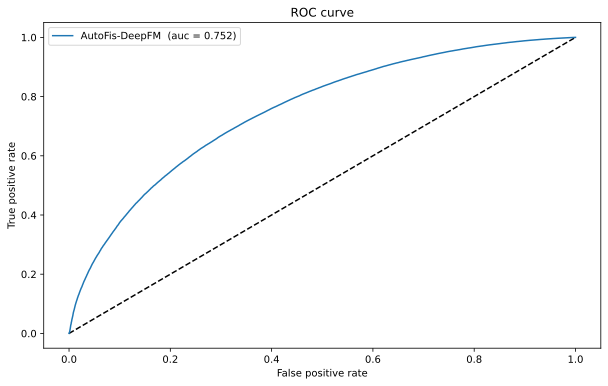

f1 score: 0.895154277559052


,precision,recall,f1-score,support
0,59.63%,19.86%,0.2980,72536.000000
1,83.29%,96.74%,0.8952,299531.000000


In [106]:
y_test = test[target]
y_proba = xdeepfm.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,model_name="AutoFis-DeepFM")

y_pred = func_out_y_pred(y_proba)
print("f1 score:",f1_score(y_test,y_pred,average="binary"))
pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).iloc[:,:2].T.style.format(
  {"precision":"{:.2%}","recall":"{:.2%}","f1-score":"{:.4f}"})

In [33]:
xdeepfm.save_weights("./output/xdeepfm_weight.h5")

#### 载入训练好的模型

In [36]:
autofis_deepfm = xDeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
autofis_deepfm.load_weights("./output/xdeepfm_weight.h5")

KS: 0.3682168734703627
roc_auc_sroce:  0.752327387333343
auc:  0.752327387333343
f1 score: 0.895154277559052


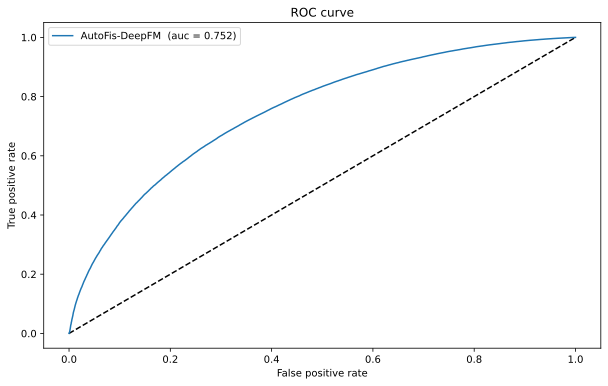

f1 score: 0.895154277559052


,precision,recall,f1-score,support
0,59.63%,19.86%,0.2980,72536.000000
1,83.29%,96.74%,0.8952,299531.000000


In [37]:
y_test = test[target]
y_proba = autofis_deepfm.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,model_name="AutoFis-DeepFM")

y_pred = func_out_y_pred(y_proba)
print("f1 score:",f1_score(y_test,y_pred,average="binary"))
pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).iloc[:,:2].T.style.format(
  {"precision":"{:.2%}","recall":"{:.2%}","f1-score":"{:.4f}"})

### 3 Wide&Deep

In [34]:
# 4.Define Model,train,predict and evaluate
##  model来自于   tf.keras.models.Model  

wide_deep = WDL(linear_feature_columns, dnn_feature_columns, task='binary')

wide_deep.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

## &train 与 test 都来自于data  train_model_input,test_model_input 也来自于data

history = wide_deep.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=epochs, verbose=2, validation_split=0.2, )

Epoch 1/50
4651/4651 - 22s - loss: 0.4362 - binary_crossentropy: 0.4362 - val_loss: 0.4262 - val_binary_crossentropy: 0.4261
Epoch 2/50
4651/4651 - 20s - loss: 0.4269 - binary_crossentropy: 0.4268 - val_loss: 0.4237 - val_binary_crossentropy: 0.4236
Epoch 3/50
4651/4651 - 20s - loss: 0.4249 - binary_crossentropy: 0.4248 - val_loss: 0.4222 - val_binary_crossentropy: 0.4221
Epoch 4/50
4651/4651 - 20s - loss: 0.4238 - binary_crossentropy: 0.4238 - val_loss: 0.4220 - val_binary_crossentropy: 0.4220
Epoch 5/50
4651/4651 - 20s - loss: 0.4230 - binary_crossentropy: 0.4229 - val_loss: 0.4227 - val_binary_crossentropy: 0.4226
Epoch 6/50
4651/4651 - 20s - loss: 0.4222 - binary_crossentropy: 0.4222 - val_loss: 0.4214 - val_binary_crossentropy: 0.4213
Epoch 7/50
4651/4651 - 20s - loss: 0.4216 - binary_crossentropy: 0.4215 - val_loss: 0.4217 - val_binary_crossentropy: 0.4216
Epoch 8/50
4651/4651 - 20s - loss: 0.4212 - binary_crossentropy: 0.4211 - val_loss: 0.4219 - val_binary_crossentropy: 0.4218


KS: 0.3673126370191725
roc_auc_sroce:  0.7519015075325782
auc:  0.7519015075325782
f1 score: 0.8937374503453291


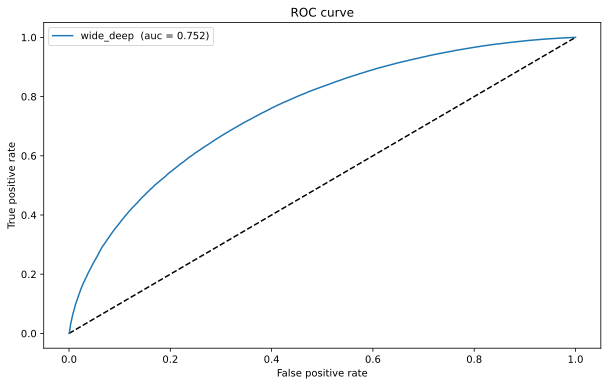

f1 score: 0.8937374503453291


,precision,recall,f1-score,support
0,57.39%,22.28%,0.3209,72536.000000
1,83.61%,96.00%,0.8937,299531.000000


In [104]:
y_test = test[target]
y_proba = wide_deep.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,model_name="wide_deep")

y_pred = func_out_y_pred(y_proba)
print("f1 score:",f1_score(y_test,y_pred,average="binary"))
pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).iloc[:,:2].T.style.format(
  {"precision":"{:.2%}","recall":"{:.2%}","f1-score":"{:.4f}"})

In [36]:
wide_deep.save_weights("./output/wide_deep_weight.h5")

#### 载入训练好的模型

In [27]:
wide_deep = WDL(linear_feature_columns, dnn_feature_columns, task='binary')
wide_deep.load_weights("./output/wide_deep_weight.h5")

KS: 0.3673126370191725
roc_auc_sroce:  0.7519015075325782
auc:  0.7519015075325782
f1 score: 0.8937374503453291


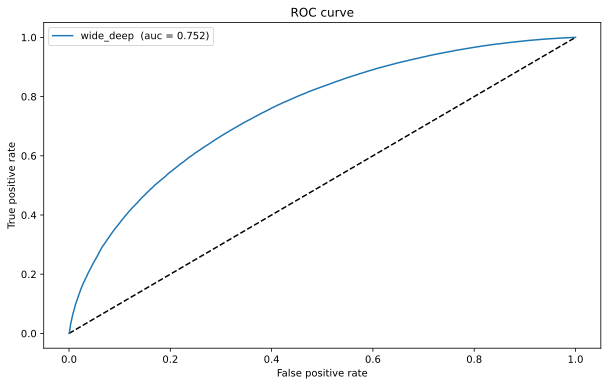

f1 score: 0.8937374503453291


,precision,recall,f1-score,support
0,57.39%,22.28%,0.3209,72536.000000
1,83.61%,96.00%,0.8937,299531.000000


In [28]:
y_test = test[target]
y_proba = wide_deep.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,model_name="wide_deep")

y_pred = func_out_y_pred(y_proba)
print("f1 score:",f1_score(y_test,y_pred,average="binary"))
pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).iloc[:,:2].T.style.format(
  {"precision":"{:.2%}","recall":"{:.2%}","f1-score":"{:.4f}"})

### 4 DeepFEFM

In [37]:
# 4.Define Model,train,predict and evaluate
##  model来自于   tf.keras.models.Model  

deepfefm = DeepFEFM(linear_feature_columns, dnn_feature_columns, task='binary')

deepfefm.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

## &train 与 test 都来自于data  train_model_input,test_model_input 也来自于data

history = deepfefm.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=epochs, verbose=2, validation_split=0.2, )

Epoch 1/50
4651/4651 - 29s - loss: 0.4356 - binary_crossentropy: 0.4355 - val_loss: 0.4261 - val_binary_crossentropy: 0.4260
Epoch 2/50
4651/4651 - 24s - loss: 0.4268 - binary_crossentropy: 0.4268 - val_loss: 0.4236 - val_binary_crossentropy: 0.4235
Epoch 3/50
4651/4651 - 24s - loss: 0.4250 - binary_crossentropy: 0.4249 - val_loss: 0.4221 - val_binary_crossentropy: 0.4220
Epoch 4/50
4651/4651 - 24s - loss: 0.4238 - binary_crossentropy: 0.4237 - val_loss: 0.4214 - val_binary_crossentropy: 0.4214
Epoch 5/50
4651/4651 - 24s - loss: 0.4229 - binary_crossentropy: 0.4228 - val_loss: 0.4221 - val_binary_crossentropy: 0.4220
Epoch 6/50
4651/4651 - 24s - loss: 0.4221 - binary_crossentropy: 0.4220 - val_loss: 0.4208 - val_binary_crossentropy: 0.4207
Epoch 7/50
4651/4651 - 24s - loss: 0.4217 - binary_crossentropy: 0.4216 - val_loss: 0.4206 - val_binary_crossentropy: 0.4205
Epoch 8/50
4651/4651 - 24s - loss: 0.4212 - binary_crossentropy: 0.4211 - val_loss: 0.4204 - val_binary_crossentropy: 0.4203


KS: 0.3635454139111283
roc_auc_sroce:  0.7478578049448465
auc:  0.7478578049448465
f1 score: 0.8950954560162714


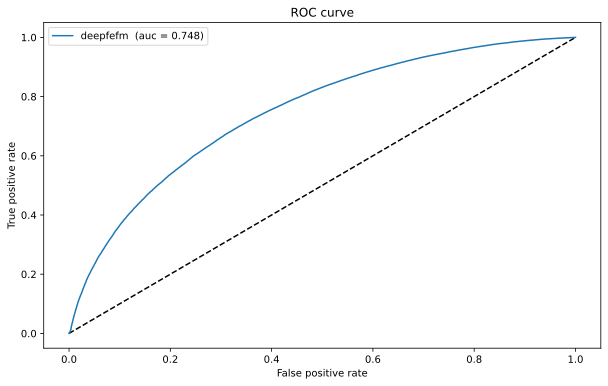

In [105]:
y_test = test[target]
y_proba = deepfefm.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,"deepfefm")

In [39]:
deepfefm.save_weights("./output/deepfefm.h5")

#### 载入训练好的模型

In [31]:
deepfefm = DeepFEFM(linear_feature_columns, dnn_feature_columns, task='binary')
deepfefm.load_weights("./output/deepfefm.h5")

KS: 0.3635454139111283
roc_auc_sroce:  0.7478578049448465
auc:  0.7478578049448465
f1 score: 0.8950954560162714


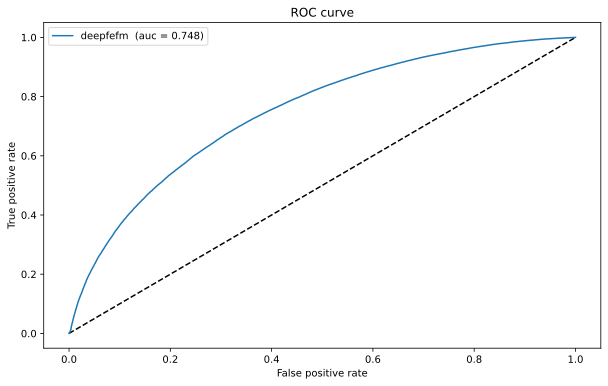

f1 score: 0.8950954560162714


,precision,recall,f1-score,support
0,59.85%,18.65%,0.2844,72536.000000
1,83.12%,96.97%,0.8951,299531.000000


In [33]:
y_test = test[target]
y_proba = deepfefm.predict(test_model_input, batch_size=256)
print_ks_auc_score(y_test,y_proba,"deepfefm")

y_pred = func_out_y_pred(y_proba)
print("f1 score:",f1_score(y_test,y_pred,average="binary"))
pd.DataFrame(classification_report(y_test,y_pred, output_dict=True)).iloc[:,:2].T.style.format(
  {"precision":"{:.2%}","recall":"{:.2%}","f1-score":"{:.4f}"})

In [ ]:
model_dict = []

### 模型结果集合展示

In [ ]:
# from sklearn.metrics import roc_curve,roc_auc_score,auc 
# import numpy as np
# import matplotlib.pyplot as plt

# def print_ks_auc_score(model,model_name):

  


In [43]:
model_list = [deepfm,autofis_deepfm,wide_deep]
model_name_list = ['deepfm','autofis_deepfm','wide_deep']

parame_dict = {}
parame_dict["fpr"] = []
parame_dict["tpr"] = []
parame_dict["auc"] = []
parame_dict["name"] = []

for i in range(len(model_name_list)):
  y_test = test[target]
  y_proba = model_list[i].predict(test_model_input, batch_size=256)
  
  fpr_keras,tpr_keras,thresholds= roc_curve(np.array(y_test),y_proba)

  auc_keras = auc(fpr_keras, tpr_keras)
  
  parame_dict["fpr"].append(fpr_keras)
  parame_dict["tpr"].append(tpr_keras)
  parame_dict["auc"].append(auc_keras)
  parame_dict["name"].append(model_name_list[i])
  
  
  

In [46]:
len(parame_dict["fpr"])

3

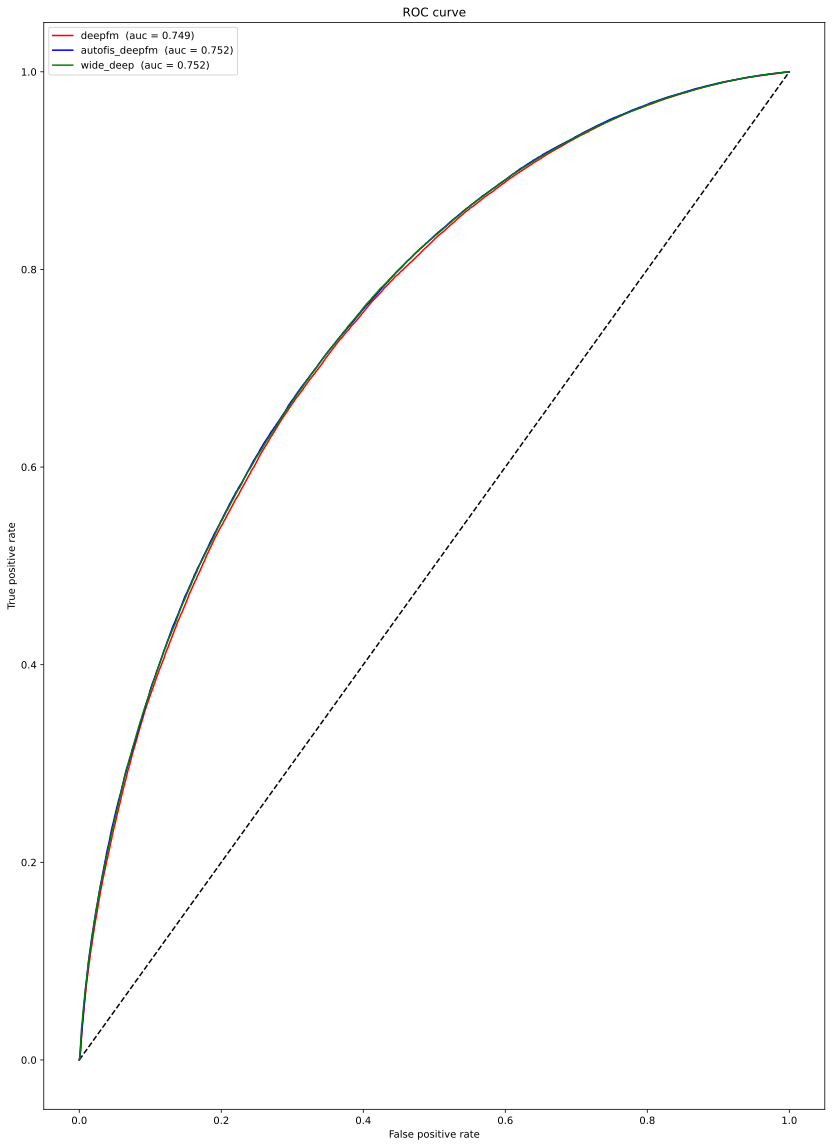

In [52]:
plt.figure(figsize=(14,20))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(parame_dict["fpr"][0], parame_dict["tpr"][0], label=parame_dict["name"][0] +'  (auc = {:.3f})'.format(parame_dict["auc"][0]),color="r")
plt.plot(parame_dict["fpr"][1], parame_dict["tpr"][1], label=parame_dict["name"][1] +'  (auc = {:.3f})'.format(parame_dict["auc"][1]),color="b")
plt.plot(parame_dict["fpr"][2], parame_dict["tpr"][2], label=parame_dict["name"][2] +'  (auc = {:.3f})'.format(parame_dict["auc"][2]),color="g")


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()